In [2]:
from hssm.wfpt.hssm import HSSM
import ssms.basic_simulators
import arviz as az

import pandas as pd
import numpy as np

/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
from typing import List, Union

import bambi as bmb
import pandas as pd

from hssm import wfpt
from hssm.wfpt.config import default_model_config
from hssm.wfpt.utils import formula_replacer

In [2]:
# !pwd

/Users/aomar7/PycharmProjects/HSSM_updated/notebooks


In [1]:
%cd /Users/aomar7/PycharmProjects/HSSM_updated/src

/Users/aomar7/PycharmProjects/HSSM_updated/src


In [17]:
model_config = {
    "analytical": {
        "model": "base",
        "list_params": ["v", "sv", "a", "z", "t"],
        "backend": "pytensor",
        "formula": "c(rt,response)  ~ 1",
        "prior": {
            "v": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
            "sv": {"name": "Uniform", "lower": 0.0, "upper": 1.2},
            "a": {"name": "Uniform", "lower": 0.5, "upper": 2.01},
            "z": {"name": "Uniform", "lower": 0.1, "upper": 0.9},
            "t": {"name": "Uniform", "lower": 0.0, "upper": 2.01},
        },
    },
    "lan": {
        "model": "test.onnx",
        "list_params": ["v", "sv", "a", "z", "theta"],
        "backend": "jax",
        "formula": "c(rt,response)  ~ 1",
        "prior": {
            "v": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
            "sv": {"name": "Uniform", "lower": 0.0, "upper": 1.2},
            "a": {"name": "Uniform", "lower": 0.5, "upper": 2.01},
            "z": {"name": "Uniform", "lower": 0.1, "upper": 0.9},
            "theta": {"name": "Uniform", "lower": 0.0, "upper": 2.01},
        },
    },
}

In [18]:
model_name = "analytical"

In [19]:
list_params = model_config[model_name]["list_params"]

In [22]:
ssm_model = wfpt.make_ssm_distribution(
    model=model_config[model_name]["model"],  # type: ignore
    list_params=list_params,  # type: ignore
    backend=model_config[model_name]["backend"],  # type: ignore
)

In [23]:
likelihood = bmb.Likelihood(
    model_config[model_name]["model"],
    params=list_params,
    parent=list_params[0],  # type: ignore
    dist=ssm_model,
)

In [72]:
include = [
    {
        "name": "v",  # change to name
        "prior": {
            "name": "Uniform",  # change to prior
            "upper": -2.01,
            "lower": 2.01,
            # "initval": 0
        },  # specify initval
        "formula": "v ~ 1 + x + y",
    },
    {
        "name": "a",  # change to name
        "prior": {
            "name": "Uniform",  # change to prior
            "upper": 1.01,
            "lower": 0.01,
            # "initval": 0
        },  # specify initval
        "formula": "a ~ 1 + x + y",
    },
]

In [25]:
family = bmb.Family(
    model_config[model_name]["model"],
    likelihood=likelihood,
    link={param: "identity" for param in list_params},
)

In [30]:
priors = {}
for param in list_params:
    priors[param] = bmb.Prior(
        model_config[model_name]["prior"][param]["name"],
        # type: ignore
        lower=model_config[model_name]["prior"][param]["lower"],
        # type: ignore
        upper=model_config[model_name]["prior"][param]["upper"],
    )

In [36]:
formula = model_config[model_name]["formula"]

In [75]:
if isinstance(include, dict) and include.get("formula"):  # type: ignore
    formula = formula_replacer(self.formula, include)
    priors[include["name"]] = bmb.Prior(
        include["prior"]["name"],
        lower=include["prior"]["lower"],
        upper=include["prior"]["upper"],
        initval=item["prior"]["initval"] if item["prior"].get("initval")
    )
elif isinstance(include, list):
    formulas = [item["formula"] for item in include if item.get("formula")]
    formula = bmb.Formula(*formulas)
    for item in include:
        priors[item["name"]] = {
            "Intercept": bmb.Prior(
                item["prior"]["name"],  # type: ignore
                lower=item["prior"]["lower"],  # type: ignore
                upper=item["prior"]["upper"],  # type: ignore
                initval=item["prior"]["initval"] if item["prior"].get("initval")
            )
        }

SyntaxError: invalid syntax (151505431.py, line 8)

In [74]:
priors

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [43]:
formulas[0]

'v ~ 1 + x + y'

In [46]:
first_item = formulas[0].split(" ~ ")[0]
# return orginal_formula.replace("1", after_plus)

In [52]:
formulas[0] = formulas[0].replace(first_item, "c(rt,response)")

In [53]:
formulas

['c(rt,response) ~ 1 + x + y', 'a ~ 1 + x + y']

In [58]:
formula = bmb.Formula(*formulas)

In [54]:
priors

{'v': {'Intercept': Uniform(lower: 2.009999990463257, upper: -2.009999990463257)},
 'sv': Uniform(lower: 0.0, upper: 1.2000000476837158),
 'a': {'Intercept': Uniform(lower: 0.009999999776482582, upper: 1.0099999904632568)},
 'z': Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421),
 't': Uniform(lower: 0.0, upper: 2.009999990463257)}

In [55]:
priors

{'v': {'Intercept': Uniform(lower: 2.009999990463257, upper: -2.009999990463257)},
 'sv': Uniform(lower: 0.0, upper: 1.2000000476837158),
 'a': {'Intercept': Uniform(lower: 0.009999999776482582, upper: 1.0099999904632568)},
 'z': Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421),
 't': Uniform(lower: 0.0, upper: 2.009999990463257)}

In [56]:
include

[{'name': 'v',
  'prior': {'name': 'Uniform', 'upper': -2.01, 'lower': 2.01},
  'formula': 'v ~ 1 + x + y'},
 {'name': 'a',
  'prior': {'name': 'Uniform', 'upper': 1.01, 'lower': 0.01},
  'formula': 'a ~ 1 + x + y'}]

In [115]:
priors

{'v': {'Intercept': Uniform(lower: 0.5, upper: 1.0)},
 'sv': Uniform(lower: 0.0, upper: 1.2000000476837158),
 'a': {'Intercept': Uniform(lower: 0.5, upper: 1.0)},
 'z': Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421),
 't': Uniform(lower: 0.0, upper: 2.0)}

In [59]:
formula

Formula('c(rt,response) ~ 1 + x + y', 'a ~ 1 + x + y')

In [92]:
priors

{'v': Uniform(lower: -3.0, upper: 3.0, initval: 0.0),
 'a': {'Intercept': Uniform(lower: 0.5, upper: 5.0, initval: 2.0)},
 'z': Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421, initval: 0.5),
 't': Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582),
 'sv': Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)}

In [ ]:
family

Family: base
Likelihood: Likelihood(  
  name: base,
  params: ['v', 'sv', 'a', 'z', 't'],
  parent: v
)
Link: {'v': Link(  
  name: identity,
  link: <function identity at 0x7fa5be4214c0>,
  linkinv: <function identity at 0x7fa5be4214c0>
), 'sv': Link(  
  name: identity,
  link: <function identity at 0x7fa5be4214c0>,
  linkinv: <function identity at 0x7fa5be4214c0>
), 'a': Link(  
  name: identity,
  link: <function identity at 0x7fa5be4214c0>,
  linkinv: <function identity at 0x7fa5be4214c0>
), 'z': Link(  
  name: identity,
  link: <function identity at 0x7fa5be4214c0>,
  linkinv: <function identity at 0x7fa5be4214c0>
), 't': Link(  
  name: identity,
  link: <function identity at 0x7fa5be4214c0>,
  linkinv: <function identity at 0x7fa5be4214c0>
)}

In [60]:
model = bmb.Model(formula, dataset, family=family, priors=priors)

'c(rt,response)  ~ 1'

In [36]:
model

       Formula: c(rt,response)  ~ 1
        Family: base
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Auxiliary parameters
            c(rt, response)_a ~ Uniform(lower: 2.009999990463257, upper: 0.5)
            c(rt, response)_sv ~ Uniform(lower: 1.2000000476837158, upper: 0.0)
            c(rt, response)_z ~ Uniform(lower: 0.8999999761581421, upper: 0.10000000149011612)
            c(rt, response)_t ~ Uniform(lower: 2.0, upper: 0.0)

In [62]:
# samples = model.fit(cores = 2, draws = 500, tune = 500)

## Simulating a dataset. 
-  dataset passed to the model should always include 'rt' and 'response'.
-  dataset should have a format of pandas dataframe.

In [3]:
import pytensor

pytensor.config.floatX = "float32"

In [4]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
obs
dataset = pd.DataFrame(obs, columns=["rt", "response"])

In [5]:
dataset["x"] = dataset["rt"] * 0.1

In [6]:
dataset["y"] = dataset["rt"] * 0.5

## Using Base WFPT class (The analytical solution of the WFPT likelihood function)

In [7]:
trace_angle_ddm_base = HSSM(data=dataset)

In [8]:
trace_angle_ddm_base.model

       Formula: c(rt,response)  ~ 1
        Family: base
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Auxiliary parameters
            c(rt, response)_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
            c(rt, response)_t ~ Uniform(lower: 0.0, upper: 2.009999990463257)
            c(rt, response)_a ~ Uniform(lower: 0.5, upper: 2.009999990463257)
            c(rt, response)_sv ~ Uniform(lower: 0.0, upper: 1.2000000476837158)

In [11]:
trace_angle_ddm_base.priors

{'v': Uniform(lower: -3.0, upper: 3.0),
 'sv': Uniform(lower: 0.0, upper: 1.2000000476837158),
 'a': Uniform(lower: 0.5, upper: 2.009999990463257),
 'z': Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421),
 't': Uniform(lower: 0.0, upper: 2.009999990463257)}

In [13]:
# samples = trace_angle_ddm_base.sample()

array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_z'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_z'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_t'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_t'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_sv'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_sv'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_a'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_a'}>]],
      dtype=object)

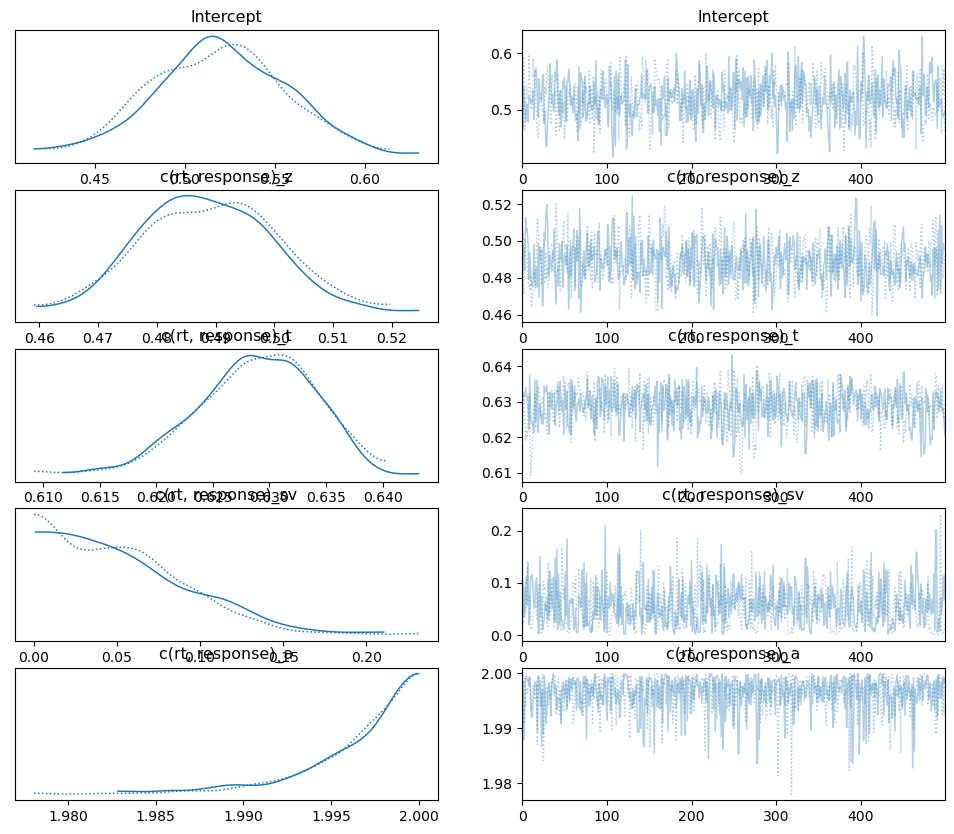

In [10]:
az.plot_trace(samples)

In [69]:
include = [
    {"param": "v", "priors": [0.5, 1], "formula": "v ~ 1 + x + y"},
    {"param": "a", "priors": [0.5, 1], "formula": "a ~ 1 + x"},
]

In [14]:
hssm_include = HSSM(
    data=dataset,
    include={
        "name": "v",  # change to name
        "prior": {
            "name": "Uniform",  # change to prior
            "upper": -2.01,
            "lower": 2.01,
        },  # specify initval
        "formula": "v ~ 1 + x + y",
    },
)

In [15]:
hssm_include.model.fit(cores=2, draws=500, tune=500)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_z, c(rt, response)_t, c(rt, response)_a, c(rt, response)_sv, Intercept, x, y]
INFO:pymc:NUTS: [c(rt, response)_z, c(rt, response)_t, c(rt, response)_a, c(rt, response)_sv, Intercept, x, y]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

ValueError: Not enough samples to build a trace.

In [30]:
hssm_include.model.fit(cores=2, draws=500, tune=500, inference_method="nuts_numpyro")

Compiling...
Compilation time =  0:00:09.636369
Sampling...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: true_fun and false_fun output must have identical types, got
(['DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])'], ['ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])'], ['DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[])'], ['DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])'], ['ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])', 'ShapedArray(float64[])'], ['DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', 'DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])']).

In [13]:
samples_two = hssm_include.sample(method=)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'c(rt, response)_t_interval__': array(nan, dtype=float32), 'c(rt, response)_a_interval__': array(nan, dtype=float32), 'c(rt, response)_z_interval__': array(nan, dtype=float32), 'c(rt, response)_sv_interval__': array(nan, dtype=float32), 'Intercept': array(-0.10231546, dtype=float32), 'x': array(-0.9175004, dtype=float32), 'y': array(-0.68998265, dtype=float32)}

Initial evaluation results:
{'c(rt, response)_t': nan, 'c(rt, response)_a': nan, 'c(rt, response)_z': nan, 'c(rt, response)_sv': nan, 'Intercept': -3.18, 'x': -4.57, 'y': -2.97, 'c(rt, response)': -inf}

In [ ]:
hssm_include = HSSM(
    data=dataset,
    include=[
        {
            "param": "v",
            "priors": ["Uniform", 0.5, 1],
            "formula": "c(rt,response) ~ 1 + x + y",
        },
        {"param": "a", "priors": ["Uniform", 0.5, 1], "formula": "a ~ 1 + x"},
    ],
)

In [ ]:
hssm_include.model

In [11]:
samples_two = hssm_include.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_z, c(rt, response)_t, c(rt, response)_sv, Intercept, x, y, a_Intercept, a_x]
INFO:pymc:NUTS: [c(rt, response)_z, c(rt, response)_t, c(rt, response)_sv, Intercept, x, y, a_Intercept, a_x]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_max

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1044 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1044 seconds.
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:130: UserWarning: In variable c(rt, response)_a, there are more dims (2) given than exist (1). Passed array should have shape (chain,draw, *shape)
  warnings.warn(


ValueError: different number of dimensions on data and dims: 3 vs 4

### Customizing sample size 

In [67]:
trace_angle_ddm_base = create_hssm(data=dataset, draws=1000, tune=600)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, sv, a, z, t]
INFO:pymc:NUTS: [v, sv, a, z, t]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Sampling 2 chains for 600 tune and 1_000 draw iterations (1_200 + 2_000 draws total) took 21 seconds.
INFO:pymc:Sampling 2 chains for 600 tune and 1_000 draw iterations (1_200 + 2_000 draws total) took 21 seconds.


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>]], dtype=object)

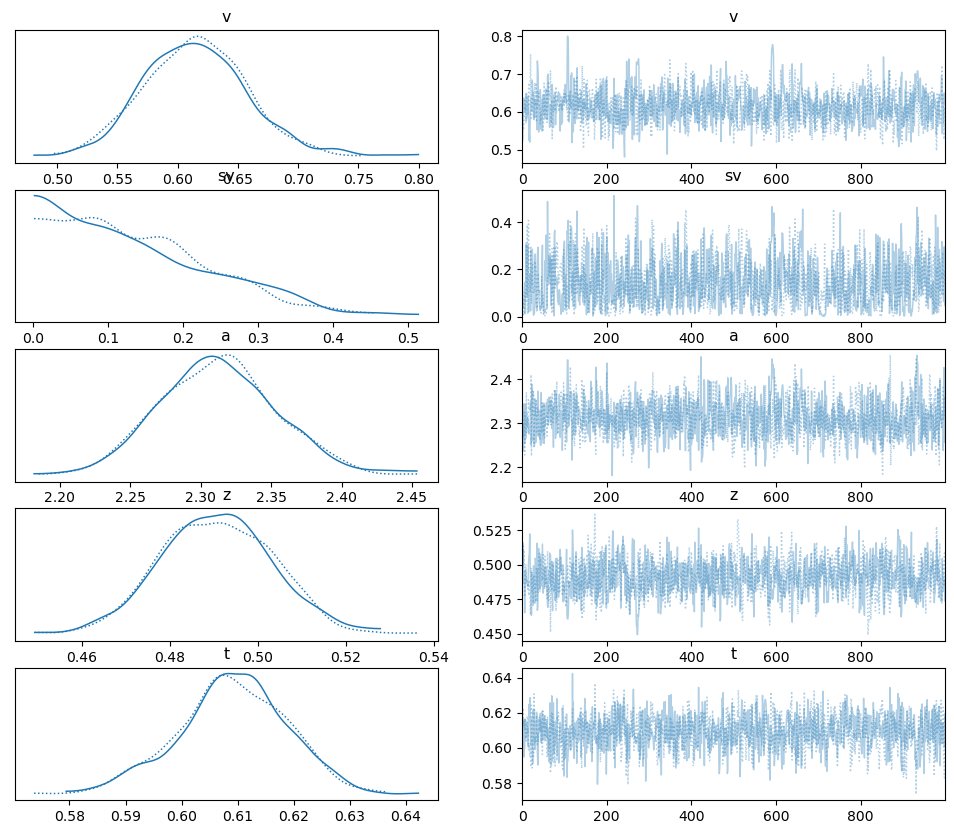

In [68]:
az.plot_trace(trace_angle_ddm_base)

## Using the lan factory functions for LAN related functionalities

### LAN using the JAX backend:

In [64]:
trace_ddm_nuts_jax_wrapped = create_hssm(
    data=dataset,
    model="lan",
)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, sv, a, z, theta]
INFO:pymc:NUTS: [v, sv, a, z, theta]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 52 seconds.


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

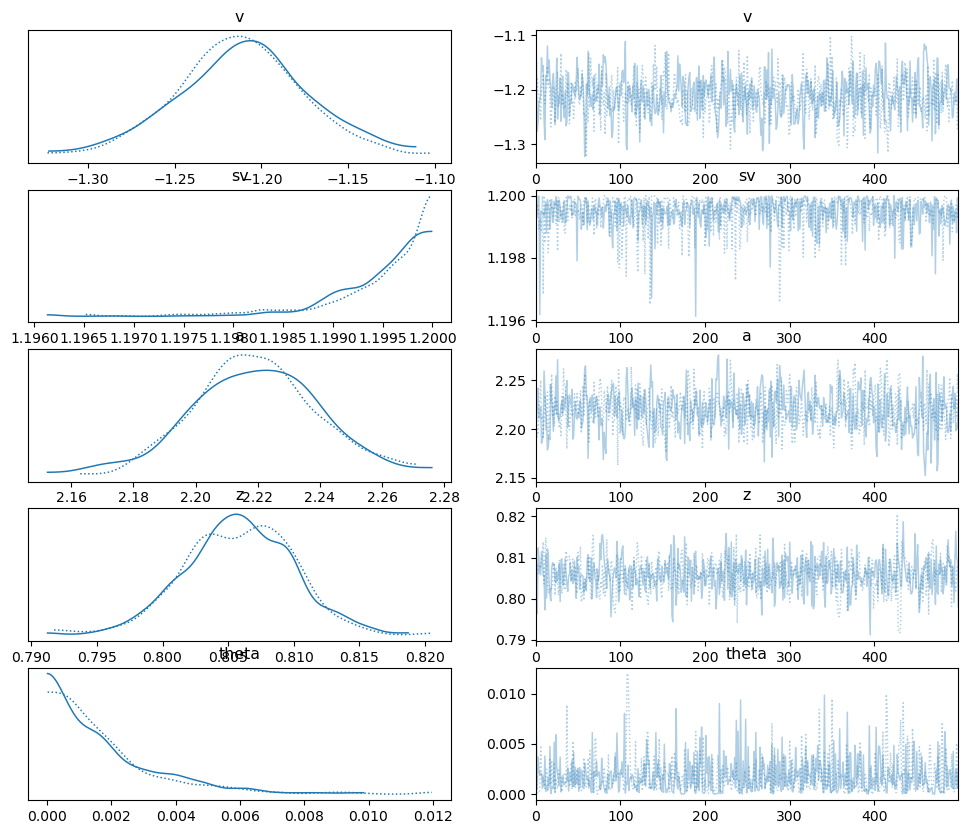

In [65]:
az.plot_trace(trace_ddm_nuts_jax_wrapped)

### Customizing sample size 

In [70]:
trace_ddm_nuts_jax_wrapped = create_hssm(
    data=dataset, model="lan", draws=1000, tune=600
)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, sv, a, z, theta]
INFO:pymc:NUTS: [v, sv, a, z, theta]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Sampling 2 chains for 600 tune and 1_000 draw iterations (1_200 + 2_000 draws total) took 60 seconds.
INFO:pymc:Sampling 2 chains for 600 tune and 1_000 draw iterations (1_200 + 2_000 draws total) took 60 seconds.


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

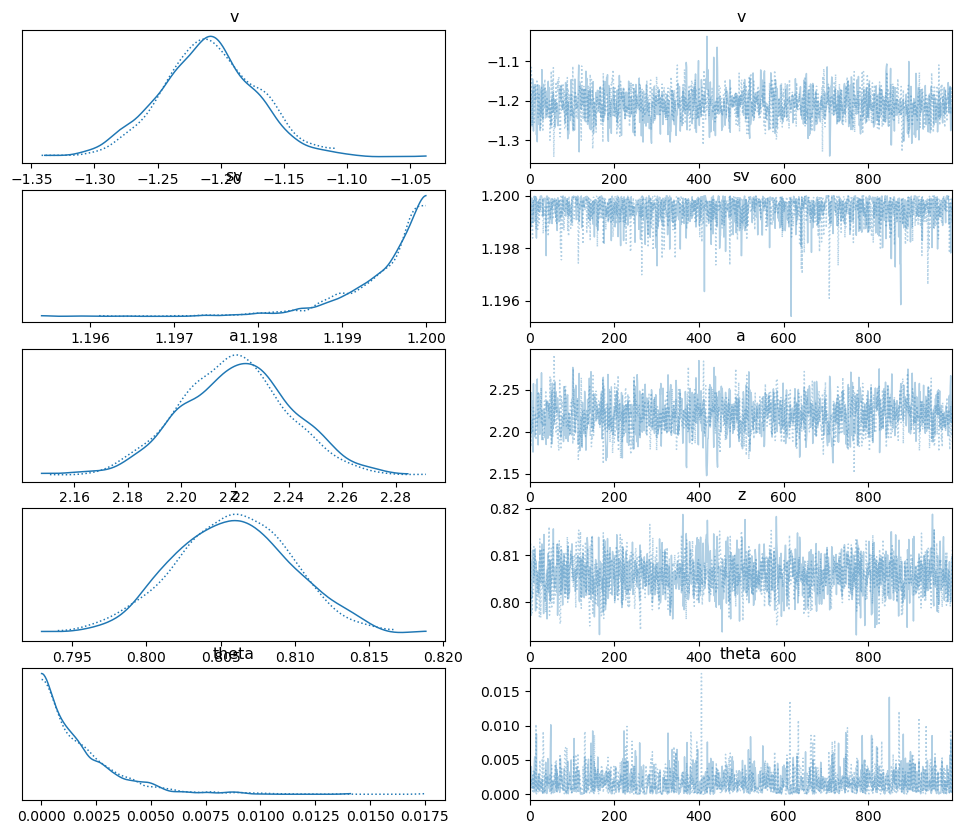

In [71]:
az.plot_trace(trace_ddm_nuts_jax_wrapped)